### Test the scarlet measurement completeness.
Do this on $gpfs

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.utils import padding_PSF
from kuaizi.detection import Data
from kuaizi import HSC_pixel_scale, HSC_zeropoint

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file, clear_download_cache

In [93]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [97]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

In [5]:
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi.task import hsc_cutout, hsc_psf

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

# Get table list from /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/unagi-0.1.3.dev13-py3.7.egg/unagi/data/s18a_wide/s18a_wide_tables.fits


In [6]:
from kuaizi.mock import Data, MockGal
import galsim

In [146]:
pos_cat = Table.read(f'{TIGRESS}/Catalog/mock_sample/skyobj_pos.fits', format='fits')
pos_cat['flux_radius_ave_i'] = np.ones(len(pos_cat)) * 5

In [147]:
pos_cat[['index', 'g_ra', 'g_dec', 'flux_radius_ave_i']].write(
    f'{TIGRESS}/Catalog/mock_sample/skyobj_pos_simple.fits', overwrite=True)

In [151]:
Table.read('./Catalog/mock_sample/MockBkg_cutout_cat_mock_sample.fits')['image_flag'].data.sum(axis=0)

array([975, 974, 977, 984])

Download bkg images

See `./lsbg_cutout_mock_bkg.sh`. The files are saved at `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/bkg`.

## Generate mock galaxies

All flat prior

SB_eff_g: 24, 28.5

R_eff: 2 arcsec, 21 arcsec

Sersic n: 0.8, 1.2

Ellipticity: 0, 0.6

Color: [0.1, 1.2]

$$ m_{\rm tot} = \overline{\mu}_{\rm eff} - 2.5 \log(2 \pi R_e^2) $$

In [164]:
np.random.seed(1234)

N_samples = 1000

SB_eff_g = np.random.uniform(24, 28.5, N_samples)
R_eff = np.random.uniform(2, 15, N_samples)
m_g = SB_eff_g - 2.5 * np.log10(2 * np.pi * R_eff**2)

sersic_n = np.random.uniform(0.8, 1.2, N_samples)
ellip = np.random.uniform(0, 0.6, N_samples)

# R_eff_sma = R_eff / np.sqrt(1 - ellip)

gi_color = np.random.normal(0.6, 0.2, N_samples)

gr_color = 0.7 * gi_color + np.random.normal(0, 0.03, N_samples)

In [165]:
param_cat = Table([Column(name='viz-id', data=np.arange(length)), 
                  Column(name='SB_eff_g', data=SB_eff_g),
                  Column(name='mag_g', data=m_g), 
                  Column(name='ellip', data=ellip), 
                  Column(name='sersic_n', data=sersic_n),
                  Column(name='g-i', data=gi_color),
                  Column(name='g-r', data=gr_color),
                  Column(name='rhalf_circularized', data=R_eff),
                  ])
param_cat.write('./Catalog/mock_sample/mock_gal_param_truth.fits', overwrite=True)

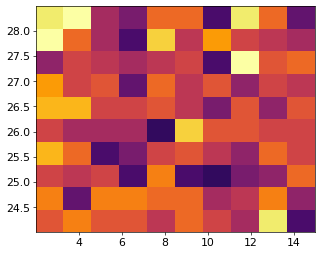

In [167]:
plt.hist2d(R_eff, SB_eff_g, vmin=0);

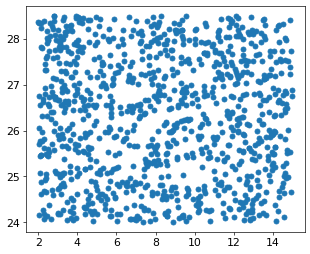

In [168]:
plt.scatter(R_eff, SB_eff_g)

In [155]:
output_dir = './Cutout/mock_sample/'

In [156]:
length = N_samples
bands = 4
lsbg_cat = Table([Column(name='viz-id', length=length, dtype=int), 
                  Column(name='ra', length=length),
                  Column(name='dec', length=length),
                  Column(name='mag_auto_i', length=length), 
                  Column(name='sersic_n', length=length),
                  Column(name='sersic_ell', length=length),
                  Column(name='sersic_PA', length=length),
                  Column(name='sersic_rhalf_circ', length=length),
                  Column(name='sersic_sed', length=length, shape=(bands,)),
                  Column(name='mags', length=length, shape=(bands,)), 
                  Column(name='prefix', length=length, dtype='S65'),
                  ])

In [157]:
from tqdm import trange

In [158]:
#for ind in trange(100, 200):
ind = 0
bkg_id = ind

#### Load bkg ####
channels = 'griz'
cutout = [fits.open(f"{TIGRESS}/Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{TIGRESS}/Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_psf_{band}.fits") for band in channels]

w = wcs.WCS(cutout[0][1].header)

images = np.array([hdu[1].data for hdu in cutout])
masks = np.array([hdu[2].data for hdu in cutout])
variances = np.array([hdu[3].data for hdu in cutout])

psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC

bkg = Data(images, variances, masks, channels, w, psfs=psf_pad)

#### Gen mock gal ####
q = 1 - ellip[ind]
gmag = m_g[ind]
gr = gr_color[ind]
gi = gi_color[ind]
imag = gmag - gi
sed = [10**(gi / (-2.5)), 10**(gi / (-2.5))  / 10**(gr / (-2.5)), 1, np.random.uniform(1.0, 1.2)]
n = sersic_n[ind]
re = R_eff[ind] # in pixel
# in galsim, re is circularized

comp1 = {
    'model': galsim.Sersic,
    'model_params': {
        'n': n,
        'half_light_radius': re,
    },
    'shear_params': {
        'q': q,
        'beta': np.random.uniform(low=-90, high=90) * galsim.degrees,
    },
    'sed': np.array(sed),
    #'n_knots': np.random.randint(0, 20),
    #'knots_frac': 0.1,
    #'knots_sed': np.array([0.2866302 , 0.2387235 , 0.20486748, 0.11319384])
}
galaxy = {'comp': [comp1],
          'imag': imag, # total mag for all components
          'flux_fraction': [1.0]
         }
mgal = MockGal(bkg)
mgal.gen_mock_lsbg(galaxy, verbose=False)
#     mgal.display()
mgal.write(os.path.join(output_dir, f'mock_{ind}.pkl'), overwrite=True)
mgal.write_fits(output_dir=output_dir,
                prefix='mock', 
                obj_id=ind, 
                overwrite=True)

obj = lsbg_cat[ind]
obj['viz-id'] = ind
obj['ra'] = mgal.mock.info['ra']
obj['dec'] = mgal.mock.info['dec']
obj['mag_auto_i'] = mgal.mock.info['imag']

model_dict = comp1
obj['sersic_n'] = model_dict['model_params']['n']
obj['sersic_rhalf_circ'] = model_dict['model_params']['half_light_radius']
obj['sersic_ell'] = 1 - model_dict['shear_params']['q']
obj['sersic_PA'] = model_dict['shear_params']['beta'].deg
obj['sersic_sed'] = model_dict['sed']
obj['mags'] = [mgal.mock.info[f'{filt}mag'] for filt in list('griz')]
obj['prefix'] = f'./Cutout/mock_sample/mock_{obj["viz-id"]}'

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

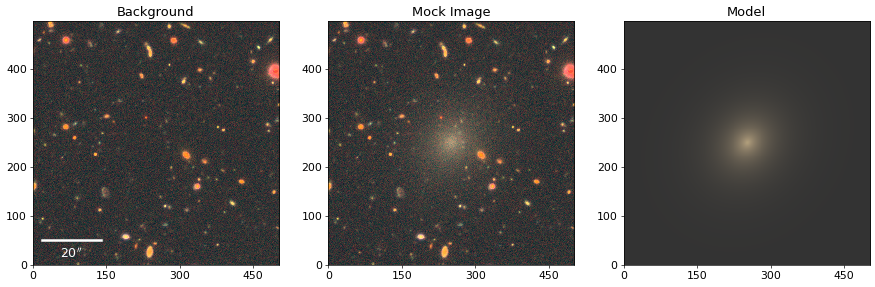

In [159]:
mgal.display()

In [160]:
mgal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.1338426937647097,
    'half_light_radius': 12.785453010214148},
   'shear_params': {'q': 0.8538161034029512,
    'beta': coord.Angle(0.8669081069308416, coord.radians)},
   'sed': array([0.58101106, 0.84549241, 1.        , 1.12044669])}],
 'imag': 17.712187806148755,
 'flux_fraction': [1.0],
 'ra': 235.49609424903161,
 'dec': 43.411166287131984,
 'gmag': 18.301726806881412,
 'rmag': 17.8944135172317,
 'zmag': 17.588709811304028}

In [161]:
SB_eff_g[ind]

25.830757079889917

In [28]:
image_flag = []
for obj in lsbg_cat:
    image_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}.fits") for filt in channels])
lsbg_cat['image_flag'] = image_flag

psf_flag = []
for obj in lsbg_cat:
    psf_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}_psf.fits") for filt in channels])
lsbg_cat['psf_flag'] = psf_flag

In [29]:
lsbg_cat.write('./Catalog/mock_sample/mock_obj_cat_3.fits', overwrite=True)

In [30]:
lsbg_cat

viz-id,ra,dec,mag_auto_i,sersic_n,sersic_ell,sersic_PA,sersic_rhalf_circ,sersic_sed [4],mags [4],prefix,image_flag [4],psf_flag [4]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes65,bool,bool
100,235.51791400661756,43.73071637581453,21.886546640786992,0.9620752878481641,0.4223670619245884,62.614119732369865,2.2594699862682983,0.3512768240231015 .. 1.104281767224674,23.022422896899762 .. 21.778846886793072,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_100,True .. True,True .. True
101,235.44921642246032,43.47318142932076,21.739598828112317,1.5797878348527028,0.22068577908829834,83.41384250023972,5.9812591501826,0.8279156839266829 .. 1.0608328671863911,21.94463355339024 .. 21.675481411187004,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_101,True .. True,True .. True
102,235.45041589875865,43.73213270597782,20.702300908660597,1.34778350091691,0.23800883596338873,-42.323359143257065,5.155809228787272,0.6276584173261123 .. 1.0823858855261164,21.20799251520019 .. 20.616345607756916,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_102,True .. True,True .. True
103,236.0456163091509,43.632663078136645,21.10004227549164,0.4440171821286166,0.34514814648067504,-3.130513959693033,9.326011952116822,0.5587982779181686 .. 1.014402708337387,21.73190462785885 .. 21.08451627535409,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_103,True .. True,True .. True
104,236.01041613216725,43.684724997443716,21.22578784986791,0.5027602488336804,0.1592749523007423,82.63146716956072,6.912215455834961,0.4335986593297158 .. 1.1394897445059113,22.133068023091244 .. 21.084011797741105,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_104,True .. True,True .. True
105,235.97997034324828,43.21689110378096,22.681112724499275,0.955668311671833,0.4211993581199863,-13.2161034644636,7.038129401372678,0.32874188836247636 .. 1.1733269052482067,23.888975110738603 .. 22.507565150805263,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_105,True .. True,True .. True
106,235.49367717952012,43.96199892368024,22.158908137938187,1.3324194012941235,0.2942105288971435,63.457701267071,5.7084724602945585,0.4934702818229786 .. 1.159793232972401,22.925755629562428 .. 21.99795671181742,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_106,True .. True,True .. True
107,235.6149773518457,43.20825059958027,20.955660942870235,0.7156496537674968,0.5306180470582547,-0.04430632030279469,3.807557355644534,0.3849866923964726 .. 1.1380519005515821,21.992046648440965 .. 20.815255771885205,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_107,True .. True,True .. True
108,236.07951164045699,43.23225115646166,20.66178356372081,0.7706170463904841,0.356718441397733,60.33504552173508,4.177448240137219,0.40925810160674725 .. 1.0083969513716218,21.631790350240983 .. 20.652704753648514,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_108,True .. True,True .. True


In [2]:
import pickle
with open('./Cutout/mock_sample/mock_58.pkl', 'rb') as fp:
    gal = pickle.load(fp)
    
gal.display()

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

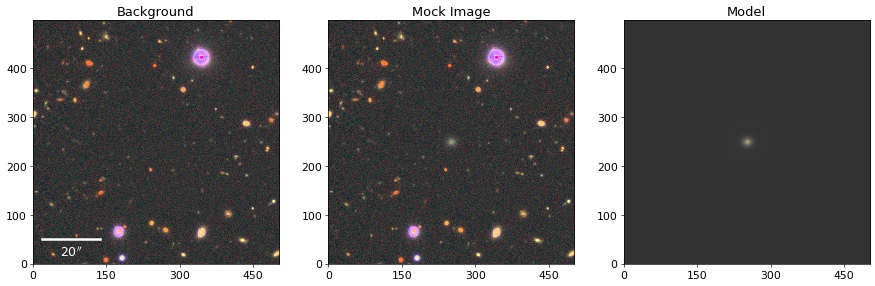